In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import re
import scipy as sp
import scipy.stats as stats
from scipy.interpolate import interp1d

import stats13tools.stats13tools as st

%matplotlib inline

In [2]:
colors = {"orange": "#f0ad4e",
          "red": "#d9534f",
          "blue": "#5bc0de",
          "green": "#5cb85c",
          "gray": "#636c72",
          "lightgray": "#d2d2d2"
         }

# The Gilbert's case

## Shifts data

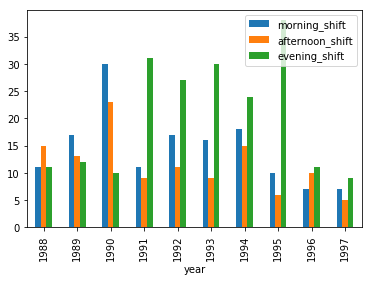

In [21]:
shifts = pd.read_csv("data-src/gilbert-data.csv")
shifts.index = shifts.year
shifts[shifts.columns[1:]].plot(kind="bar");

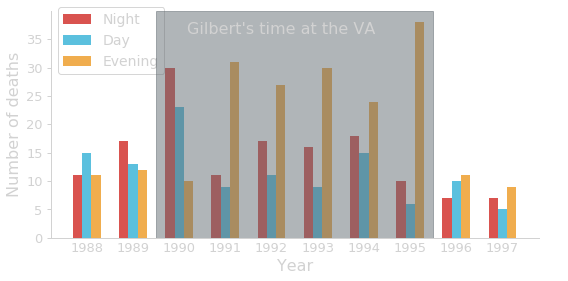

In [193]:
fig,ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()

width=0.6
scale = 3.

colors_list = ["red", "blue", "orange"]
labels_list = ["Night", "Day", "Evening"]
xpos = np.arange(len(shifts.year))*scale

for i,shift in enumerate(shifts.columns[1:]):
    ax1.bar(xpos+width*i, shifts[shift], width=width, color=colors[colors_list[i]], label=labels_list[i]);
    
for spine in ["bottom", "left"]:
    ax1.spines[spine].set_linewidth(1)
    ax1.spines[spine].set_color(colors["lightgray"])
for spine in ["top", "right"]:
    ax1.spines[spine].set_visible(False)

for ax in [ax1]:
    ax.set_xticks(xpos+width)
    ax.set_xticklabels(shifts.year)
    ax.set_ylim(0)
    ax.tick_params(axis="y", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.tick_params(axis="x", size=0, labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.set_xlabel("Year", size=16, color=colors["lightgray"])
    ax.set_ylabel("Number of deaths", size=16, color=colors["lightgray"])
    legend = ax.legend(prop=dict(size=14), loc="upper left", frameon=True, facecolor="none",
                      bbox_to_anchor=(0, 1.05))
    for text in legend.get_texts():
        text.set_color(colors["lightgray"])
        
for ax in [ax2]:
    ax2.axis("off")
    ax.axvspan(xpos[2]-1.5*width, xpos[8]-1.5*width, alpha=0.5, color=colors["gray"])
    ax.text(xpos[2]-1.5*width+(xpos[8]-1.5*width-xpos[2]-1.5*width)/2, 
            ax.get_ylim()[1]*0.9, "Gilbert's time at the VA", color=colors["lightgray"], 
           ha="center", size=16)
    
plt.tight_layout()
    
plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/gilbert-case-shifts-pattern.svg", transparent=True)

## Relative risk

In [213]:
data = pd.DataFrame({"shift_gilbert": [40, 217],
                     "shift_no_gilbert": [34, 1350]}, index=["death", "no_death"])
data

,shift_gilbert,shift_no_gilbert
death,40,34
no_death,217,1350


In [214]:
data.shift_gilbert/data.shift_gilbert.sum()

death       0.155642
no_death    0.844358
Name: shift_gilbert, dtype: float64

In [215]:
data.shift_no_gilbert/data.shift_no_gilbert.sum()

death       0.024566
no_death    0.975434
Name: shift_no_gilbert, dtype: float64

In [216]:
rr = (data.shift_gilbert/data.shift_gilbert.sum()).death/(data.shift_no_gilbert/data.shift_no_gilbert.sum()).death
print("Relative risk: {:.5f}".format(rr))

Relative risk: 6.33555


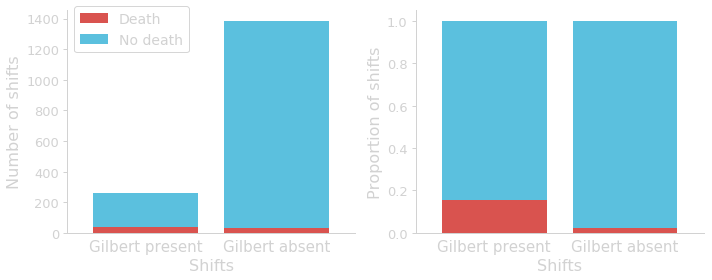

In [218]:
fig,(ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))


ax1.bar(np.arange(2), data.ix["death"], color=colors['red'], label="Death");
ax1.bar(np.arange(2), data.ix["no_death"], bottom=data.ix["death"], color=colors['blue'], label="No death");

ax2.bar(np.arange(2), data.ix["death"]/data.sum(), color=colors['red']);
ax2.bar(np.arange(2), data.ix["no_death"]/data.sum(), bottom=data.ix["death"]/data.sum(), color=colors['blue']);


for ax in [ax1, ax2]:
    for spine in ["bottom", "left"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels(["Gilbert present", "Gilbert absent"])
    ax.set_ylim(0)
    ax.tick_params(axis="y", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.tick_params(axis="x", size=0, labelcolor=colors["lightgray"], 
                   labelsize=15, pad=6)
    ax.set_xlim(-0.6, 1.6)
    ax.set_xlabel("Shifts", size=16, color=colors["lightgray"])
    
for ax in [ax1]:
    ax.set_ylabel("Number of shifts", size=16, color=colors["lightgray"])
    legend = ax.legend(prop=dict(size=14), loc="upper left", frameon=True, facecolor="none",
                      bbox_to_anchor=(0, 1.05))
    for text in legend.get_texts():
        text.set_color(colors["lightgray"])

for ax in [ax2]:
    ax.set_ylabel("Proportion of shifts", size=16, color=colors["lightgray"])

        
plt.tight_layout()

    
plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/gilbert-case-death-pattern-during-shifts.svg", transparent=True)

# Null hypothesis testing (Shuffling)

In [219]:
data

,shift_gilbert,shift_no_gilbert
death,40,34
no_death,217,1350


In [220]:
print("Total number of shifts: {}".format(data.values.sum()))
print("Proportion of shifts for which death occured: {}".format(data.ix["death"].sum()/data.values.sum()))

Total number of shifts: 1641
Proportion of shifts for which death occured: 0.04509445460085314


#### If death was equally likely to happen during the shifts with and without Gilbert present, then the proportion of shifts with death should be the same for both conditions

In [222]:
#the population is all the shifts, with as many 1 as shift with death
all_shifts = np.zeros(data.values.sum())
all_shifts[:data.ix["no_death"].sum()]=1

In [229]:
n_simul = 10000
res_diff = np.zeros(n_simul) #store the data
res_relativerisk = np.zeros(n_simul) #store the data
n_shift_gilbert = data.shift_gilbert.sum() #number of shifts with Gilbert present
n_shift_no_gilbert = data.shift_no_gilbert.sum() #number of shifts without Gilbert present

#each simulation is the shuffling of the full population and the
#calculation of the difference in proportion of shifts with death
for i in range(n_simul):
    np.random.shuffle(all_shifts)
    with_gilbert = all_shifts[:n_shift_gilbert]
    without_gilbert = all_shifts[n_shift_gilbert:]
    deathprop_with_gilbert = np.sum(with_gilbert)/n_shift_gilbert
    deathprop_without_gilbert = np.sum(without_gilbert)/n_shift_no_gilbert
    difference = deathprop_with_gilbert-deathprop_without_gilbert
    relativerisk = deathprop_with_gilbert/deathprop_without_gilbert
    res_diff[i] = difference
    res_relativerisk[i] = relativerisk

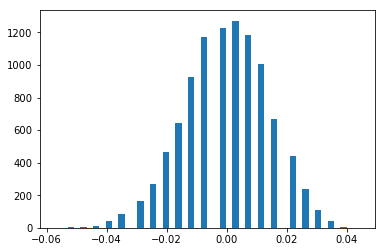

In [231]:
plt.hist(res_diff, bins="auto");


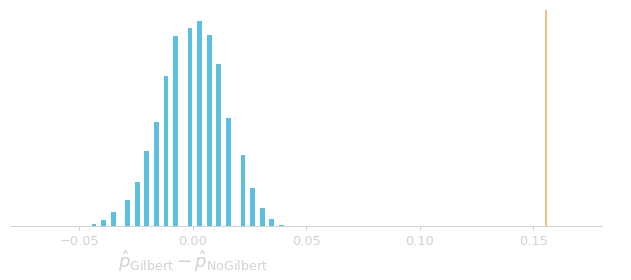

In [246]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_axes([0.1, 0.15, 0.82, 0.75])
ax2 = ax1.twinx()
ax3 = ax1.twinx()
    
for ax in [ax1]:
    ax.hist(res_diff, bins="auto", color=colors["blue"])
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.text(0, -250, '$\hat{p}_{\mathrm{Gilbert}}-\hat{p}_{\mathrm{No Gilbert}}$', size=18, color=colors["lightgray"], ha="center")
    ax.set_ylim(0)
    ax.set_xlim(-0.08, 0.18)
    
for ax in [ax2]:
    ax.axvline(data.ix["death"].shift_gilbert/data.shift_gilbert.sum(), color=colors["orange"])

for ax in [ax2, ax3]:
    ax.set_ylim(0)
    ax.axis("off")

#plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/salaries-ucla2014-resampling-ttest.svg", transparent=True)

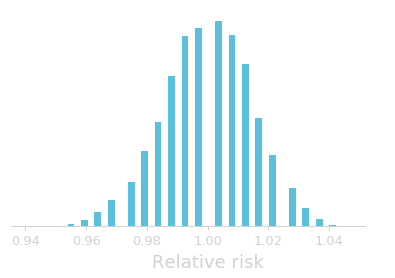

In [253]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes([0.1, 0.15, 0.82, 0.75])
ax2 = ax1.twinx()
ax3 = ax1.twinx()
    
for ax in [ax1]:
    ax.hist(res_relativerisk, bins="auto", color=colors["blue"])
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.text(1, -250, 'Relative risk', size=18, color=colors["lightgray"], ha="center")
    ax.set_ylim(0)
    #ax.set_xlim(0.85, 7)
    
#for ax in [ax2]:
#    ax.axvline(rr, color=colors["orange"])

for ax in [ax2, ax3]:
    ax.set_ylim(0)
    ax.axis("off")

#plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/salaries-ucla2014-resampling-ttest.svg", transparent=True)

In [254]:
0.156-0.025

0.131

# One sample mean (t distribution)

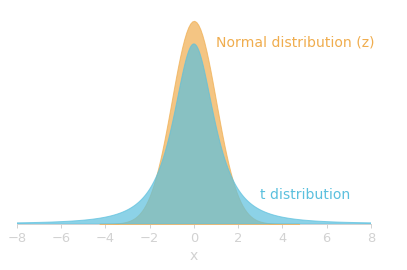

In [3]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes([0.1, 0.15, 0.82, 0.74])
ax2 = ax1.twinx()


   
#normal distribution
xnorm = np.linspace(stats.norm.ppf(0.00001),
                 stats.norm.ppf(0.999999), 100)
ynorm = stats.norm.pdf(xnorm)

#t distribution
xt = np.linspace(-10, 10, 1000)
yt = stats.t(2, 0).pdf(xt)

ax1.fill_between(xnorm, ynorm, color=colors["orange"], alpha=0.7, zorder=100)
ax2.fill_between(xt, yt, color=colors["blue"], alpha=0.7, zorder=100)
#ax2.plot(xt, stats.t(1E10, 0).pdf(xt))


for spine in ["bottom"]:
    ax1.spines[spine].set_linewidth(1)
    ax1.spines[spine].set_color(colors["lightgray"])
for spine in ["top", "right", "left"]:
    ax1.spines[spine].set_visible(False)

for ax in [ax1]:
    ax.set_yticks([])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.set_xlabel("x", size=14, color=colors["lightgray"])
    ax.set_xlim(-8, 8)
    ax.set_ylim(0)
    ax.text(1, 0.35, "Normal distribution (z)", size=14, color=colors["orange"])
    ax.text(3, 0.05, "t distribution", size=14, color=colors["blue"])

for ax in [ax2]:
    ax.set_ylim(ax1.get_ylim())
    ax.axis("off")
    
 

   
plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/distribution-t-vs-z.svg", transparent=True)

In [163]:
sd = np.sqrt((14/16*(1-14/16))/16)
sd

0.08267972847076846

In [168]:
n_simul = 10000
results = np.zeros(n_simul)
population = np.zeros(16)
population[:14]=1

for i in range(n_simul):
    sample = np.random.choice(population, 16)
    count = np.sum(sample)
    phat = count/16
    results[i] = phat
    

# UCLA salaries (2014)

## Full population

In [42]:
data_original = pd.read_csv("data-src/salaries-ucla2014.csv")
#data = data_original.loc[(data_original.NAME != "***** , *****") & (data_original.BASE >= 12000), "GROSS"]
data = data_original.loc[(data_original.NAME != "***** , *****") & (data_original.BASE >= 12000)] #in 2014, there was no base salary < 12000

In [43]:
print("Min salary:\n {} => {}".format(data[data.GROSS==data.GROSS.min()].NAME.values[0], data[data.GROSS==data.GROSS.min()].GROSS.values[0]))
print("Max salary:\n {} => {}".format(data[data.GROSS==data.GROSS.max()].NAME.values[0], data[data.GROSS==data.GROSS.max()].GROSS.values[0]))

Min salary:
 DADASHIAN , EMAN L => 2000
Max salary:
 MORA , JAMES LAWRENCE => 3476127


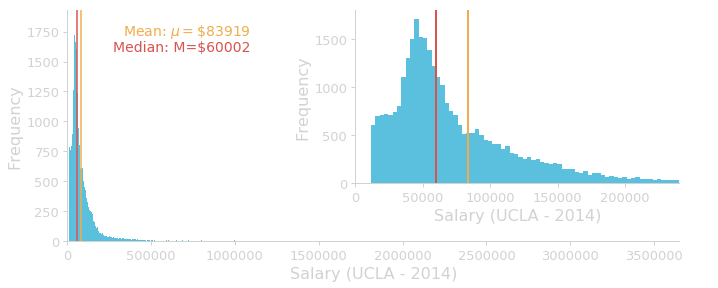

In [258]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_axes([0.1, 0.15, 0.85, 0.8])
ax2 = ax1.twinx()
ax3 = fig.add_axes([0.5, 0.35, 0.45, 0.6])


ax1.hist(data.GROSS, bins="auto", color=colors["blue"]);
ax3.hist(data.loc[data.GROSS<240000, "GROSS"], bins="auto", color=colors["blue"]);

for ax in [ax1, ax3]:
    for spine in ["bottom", "left"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

for ax in [ax1, ax3]:
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_xlabel("Salary (UCLA - 2014)", size=16, color=colors["lightgray"])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.set_ylabel("Frequency", size=16, color=colors["lightgray"])
    
for ax in [ax2]:
    ax.set_ylim(ax1.get_ylim())
    ax.axis("off")
    ax.axvline(data.GROSS.mean(), color=colors["orange"])
    ax.axvline(data.GROSS.median(), color=colors["red"])
    ax.text(ax.get_xlim()[1]*0.3, ax.get_ylim()[1]*0.95, "Mean: $\mu=\$${:.0f}".format(data.GROSS.mean()), size=14, color=colors["orange"], ha="right", va="top")
    ax.text(ax.get_xlim()[1]*0.3, ax.get_ylim()[1]*0.87, "Median: M=${:.0f}".format(data.GROSS.median()), size=14, color=colors["red"], ha="right", va="top")

for ax in [ax3]:
    ax.set_xlim(0, 240000)
    ax.axvline(data.GROSS.mean(), color=colors["orange"], lw=2)
    ax.axvline(data.GROSS.median(), color=colors["red"], lw=2)
    
#plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/salaries-ucla2014-all.svg", transparent=True)

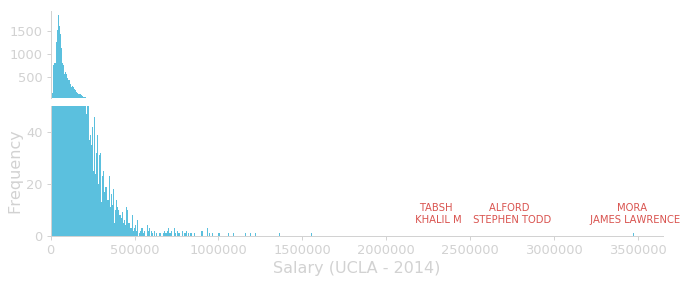

In [8]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_axes([0.1, 0.15, 0.85, 0.45])
ax2 = fig.add_axes([0.1, 0.63, 0.85, 0.3])

for ax in [ax1, ax2]:
    ax.hist(data.GROSS, bins="auto", color=colors["blue"]);
    
for spine in ["bottom", "left"]:
    ax1.spines[spine].set_linewidth(1)
    ax1.spines[spine].set_color(colors["lightgray"])
for spine in ["top", "right"]:
    ax1.spines[spine].set_visible(False)

for ax in [ax1]:
    ax.set_xlim(0)
    ax.set_ylim(0, 50)
    ax.set_xlabel("Salary (UCLA - 2014)", size=16, color=colors["lightgray"])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    #ax.text(-300000, 50, "Frequency", size=16, color=colors["lightgray"], rotation=90)
    ax.set_ylabel("Frequency", size=16, color=colors["lightgray"])
    for big_salary in data.GROSS.sort_values().values[-3:]:
        ax.text(big_salary, 5, "{}\n{}".format(data[data.GROSS==big_salary].NAME.values[0].split(",")[0], 
                                                 data[data.GROSS==big_salary].NAME.values[0].split(",")[1]),
                size=10, color=colors["red"], ha="center")

for ax in [ax2]:
    ax.set_xlim(0)
    ax.set_xticks([])
    ax.set_ylim(50)
    for spine in ["left"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "bottom"]:
        ax.spines[spine].set_visible(False)
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    

#plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/salaries-ucla2014-zoom.svg", transparent=True)

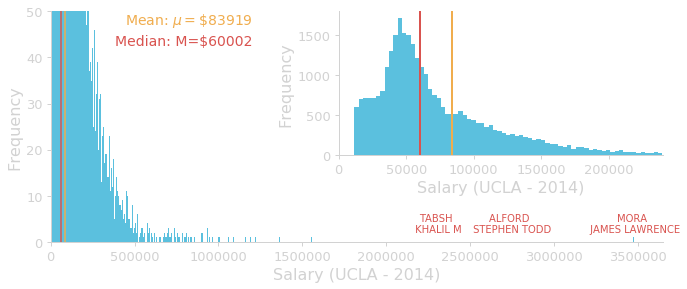

In [167]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_axes([0.1, 0.15, 0.85, 0.80])
ax2 = fig.add_axes([0.5, 0.45, 0.45, 0.5])

for ax in [ax1]:
    ax.hist(data.GROSS, bins="auto", color=colors["blue"]);
    ax.axvline(data.GROSS.mean(), color=colors["orange"])
    ax.axvline(data.GROSS.median(), color=colors["red"])
    
for spine in ["bottom", "left"]:
    ax1.spines[spine].set_linewidth(1)
    ax1.spines[spine].set_color(colors["lightgray"])
for spine in ["top", "right"]:
    ax1.spines[spine].set_visible(False)

for ax in [ax1]:
    ax.set_xlim(0)
    ax.set_ylim(0, 50)
    ax.set_xlabel("Salary (UCLA - 2014)", size=16, color=colors["lightgray"])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    #ax.text(-300000, 50, "Frequency", size=16, color=colors["lightgray"], rotation=90)
    ax.set_ylabel("Frequency", size=16, color=colors["lightgray"])
    for big_salary in data.GROSS.sort_values().values[-3:]:
        ax.text(big_salary, 2, "{}\n{}".format(data[data.GROSS==big_salary].NAME.values[0].split(",")[0], 
                                                 data[data.GROSS==big_salary].NAME.values[0].split(",")[1]),
                size=10, color=colors["red"], ha="center")
    ax.text(ax.get_xlim()[1]*0.33, ax.get_ylim()[1]*1, "Mean: $\mu=\$${:.0f}".format(data.GROSS.mean()), size=14, color=colors["orange"], ha="right", va="top")
    ax.text(ax.get_xlim()[1]*0.33, ax.get_ylim()[1]*0.9, "Median: M=${:.0f}".format(data.GROSS.median()), size=14, color=colors["red"], ha="right", va="top")

    
ax2.hist(data.loc[data.GROSS<240000, "GROSS"], bins="auto", color=colors["blue"]);

for ax in [ax2]:
    for spine in ["bottom", "left"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_xlabel("Salary (UCLA - 2014)", size=16, color=colors["lightgray"])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.set_ylabel("Frequency", size=16, color=colors["lightgray"])
    ax.set_xlim(0, 240000)
    ax.axvline(data.GROSS.mean(), color=colors["orange"], lw=2)
    ax.axvline(data.GROSS.median(), color=colors["red"], lw=2)
    
plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/salaries-ucla2014-zoom.svg", transparent=True)

## Sample

In [44]:
n_sample = 100
ucla_sample_idx = np.random.choice(data.index.values, replace=False, size=n_sample)

ucla_sample = data.ix[ucla_sample_idx]

In [67]:
print("Sample mean: {}".format(ucla_sample.GROSS.mean()))
print("Sample std: {}".format(ucla_sample.GROSS.std()))

Sample mean: 80918.55
Sample std: 63955.95784606448


In [51]:
#savesample data to csv to be generated as table via d3
pd.DataFrame(np.concatenate([list(ucla_sample.GROSS.values), ["-" for i in range(2)]]).reshape((17,6))).to_csv("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/d3-anim/js-graphs/js-graphs-data-src/salaries-ucla-sample.csv",
                                                              index=False, header=False)

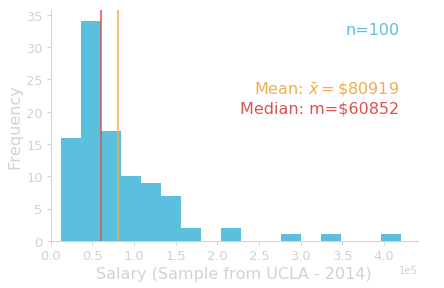

In [52]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes([0.11, 0.15, 0.85, 0.8])
ax2 = ax1.twinx()

ax1.hist(ucla_sample.GROSS, bins="auto", color=colors["blue"]);
    
for spine in ["bottom", "left"]:
    ax1.spines[spine].set_linewidth(1)
    ax1.spines[spine].set_color(colors["lightgray"])
for spine in ["top", "right"]:
    ax1.spines[spine].set_visible(False)

for ax in [ax1]:
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_xticks(np.arange(0, ucla_sample.GROSS.max()+1, 50000))
    ax.set_xlabel("Salary (Sample from UCLA - 2014)", size=16, color=colors["lightgray"])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,5))
    ax.set_ylabel("Frequency", size=16, color=colors["lightgray"])
    ax.text(ax.get_xlim()[1]*0.95, ax.get_ylim()[1]*0.95, "n={:.0f}".format(len(ucla_sample)), size=16, color=colors["blue"], ha="right", va="top")
    
for ax in [ax2]:
    ax.set_ylim(ax1.get_ylim())
    ax.axis("off")
    ax.axvline(ucla_sample.GROSS.mean(), color=colors["orange"])
    ax.axvline(ucla_sample.GROSS.median(), color=colors["red"])
    ax.text(ax.get_xlim()[1]*0.95, ax.get_ylim()[1]*0.7, r"Mean: $\bar{{x}}=$\${:.0f}".format(ucla_sample.GROSS.mean()), size=16, color=colors["orange"], ha="right", va="top")
    ax.text(ax.get_xlim()[1]*0.95, ax.get_ylim()[1]*0.61, "Median: m=${:.0f}".format(ucla_sample.GROSS.median()), size=16, color=colors["red"], ha="right", va="top")


plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/salaries-ucla2014-sample.svg", transparent=True)

### National US data (2014)

https://www.census.gov/data/tables/time-series/demo/income-poverty/cps-pinc/pinc-01.2014.html

In [53]:
census2014 = {"mean": 62931,
              "median": 46480}

### bootstrap ci

In [54]:
n_simul = 10000
res_ucla_mean = np.zeros(n_simul)
res_ucla_median = np.zeros(n_simul)

for i in range(n_simul):
    res_ucla_mean[i]=np.random.choice(ucla_sample.GROSS.values, size=len(ucla_sample)).mean()
    res_ucla_median[i]=np.median(np.random.choice(ucla_sample.GROSS.values, size=len(ucla_sample)))

ucla_mean_ci = [np.percentile(res_ucla_mean, 2.5), np.percentile(res_ucla_mean, 97.5)]
ucla_median_ci = [np.percentile(res_ucla_median, 2.5), np.percentile(res_ucla_median, 97.5)]

In [55]:
print("Mean 95% ci: [{:.2f}, {:.2f}]".format(ucla_mean_ci[0], ucla_mean_ci[1]))
print("Median 95% ci: [{:.2f}, {:.2f}]".format(ucla_median_ci[0], ucla_median_ci[1]))

Mean 95% ci: [69280.04, 94209.56]
Median 95% ci: [52654.00, 67275.81]


### t statistic


In [56]:
ucla_sample.GROSS.std()

63955.95784606448

In [57]:
ucla_sample_se = ucla_sample.GROSS.std()/np.sqrt(len(ucla_sample))
t_ucla = (ucla_sample.GROSS.mean()-census2014["mean"])/ucla_sample_se
t_ucla

2.8124901269236271

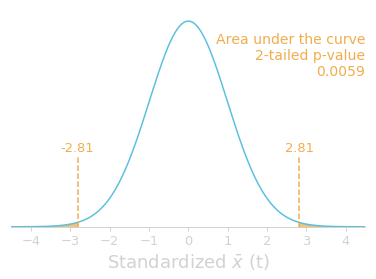

In [58]:
#t distribution
tdist_ucla = stats.t(df=len(ucla_sample)-1, loc=0, scale=1)
xt0_ucla = np.linspace(-4.5, 4.5, 1000)
yt0_ucla = tdist_ucla.pdf(xt0_ucla)


fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes([0.1, 0.15, 0.82, 0.75])
   
for ax in [ax1]:
    ax.plot(xt0_ucla, yt0_ucla, color=colors["blue"], lw=1.5)
    ax.fill_between(xt0_ucla[xt0_ucla<-t_ucla], yt0_ucla[xt0_ucla<-t_ucla],
                       color=colors["orange"], alpha=0.7)
    ax.fill_between(xt0_ucla[xt0_ucla>t_ucla], yt0_ucla[xt0_ucla>t_ucla],
                        color=colors["orange"], alpha=0.7) 
    ax.axvline(t_ucla, ymax=0.33, color=colors["orange"], ls="--")
    ax.axvline(-t_ucla, ymax=0.33, color=colors["orange"], ls="--")
    ax.text(t_ucla, ax.get_ylim()[1]*0.35, "{:.2f}".format(t_ucla), color=colors["orange"], size=13, ha="center")
    ax.text(-t_ucla, ax.get_ylim()[1]*0.35, "{:.2f}".format(-t_ucla), color=colors["orange"], size=13, ha="center")
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.set_xlabel(r'Standardized $\bar{x}$ (t)', size=18, color=colors["lightgray"])
    ax.set_xlim(xt0_ucla.min(), xt0_ucla.max())
    ax.set_ylim(0)
    ax.text(ax.get_xlim()[1]*1, ax.get_ylim()[1]*0.7, "Area under the curve\n2-tailed p-value\n{:.4f}".format(stats.t.sf(np.abs(t_ucla), len(ucla_sample)-1)*2),
           ha="right", color=colors["orange"], size=14)
    
    

plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/salaries-ucla2014-ttest.svg", transparent=True)

In [59]:
print("p-value (two-tailed):", stats.t.sf(np.abs(t_ucla), len(ucla_sample)-1)*2)

p-value (two-tailed): 0.00592857121536


### resampling vs t distribution

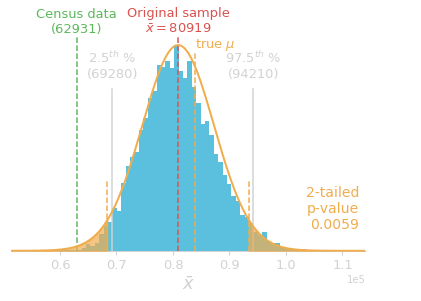

In [66]:
#t distribution
tdist_ucla = stats.t(df=len(ucla_sample)-1, loc=ucla_sample.GROSS.mean(), scale=(ucla_sample.GROSS.std())/np.sqrt(len(ucla_sample)))
xt_ucla = np.linspace(res_ucla_mean.min()-7000, res_ucla_mean.max()+5000, 100000)
yt_ucla = tdist_ucla.pdf(xt_ucla)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes([0.1, 0.15, 0.82, 0.75])
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()
ax5 = ax1.twinx()
ax6 = ax1.twinx()
ax7 = ax1.twinx()
ax8 = ax1.twinx()
    
for ax in [ax1]:
    ax.hist(res_ucla_mean, bins="auto", color=colors["blue"])
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.set_xlabel(r'$\bar{x}$', size=18, color=colors["lightgray"])
    ax.set_xlim(xt_ucla.min(), xt_ucla.max())
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,5))
    ax.set_ylim(0)
    
for ax in [ax2]:
    ax.set_ylim(ax1.get_ylim())
    ax.axvline(ucla_sample.GROSS.mean(), color=colors["red"], ls="--")
    ax.text(ucla_sample.GROSS.mean(), ax.get_ylim()[1]*1.01, "Original sample\n" r"$\bar{{x}}=$" "{:.0f}".format(ucla_sample.GROSS.mean()), color=colors["red"], size=13, ha="center")
 
for ax in [ax3]:
    ax.axvline(ucla_mean_ci[0], ymax=0.75, color=colors["lightgray"], ls="-")
    ax.axvline(ucla_mean_ci[1], ymax=0.75, color=colors["lightgray"], ls="-")
    ax.text(ucla_mean_ci[0], ax.get_ylim()[1]*0.8, "2.5$^{{th}}$ %\n({:.0f})".format(ucla_mean_ci[0]), color=colors["lightgray"], size=13, ha="center")
    ax.text(ucla_mean_ci[1], ax.get_ylim()[1]*0.8, "97.5$^{{th}}$ %\n({:.0f})".format(ucla_mean_ci[1]), color=colors["lightgray"], size=13, ha="center")

for ax in [ax4]:
    ax.axvline(census2014["mean"], color=colors["green"], ls="--")
    ax.text(census2014["mean"], ax.get_ylim()[1]*1.01, "Census data\n({:.0f})".format(census2014["mean"]), color=colors["green"], size=13, ha="center")

for ax in [ax8]:
    ax.axvline(data.GROSS.mean(), ymax=0.92, color=colors["orange"], ls="--")
    ax.text(data.GROSS.mean(), ax.get_ylim()[1]*0.94, "true $\mu$", color=colors["orange"], size=13, ha="left")

for ax in [ax5]:
    ax.plot(xt_ucla, yt_ucla, color=colors["orange"], lw=2)
    
for ax in [ax2, ax3, ax4, ax5, ax8]:
    ax.set_ylim(0)
    ax.axis("off")

for ax in [ax6]:
    ax.set_ylim(ax5.get_ylim())
    ax.axis("off")
    ax.fill_between(xt_ucla[xt_ucla<ucla_sample.GROSS.mean()-1.96*ucla_sample_se], yt_ucla[xt_ucla<ucla_sample.GROSS.mean()-1.96*ucla_sample_se],
                       color=colors["orange"], alpha=0.7)
    ax.fill_between(xt_ucla[xt_ucla>ucla_sample.GROSS.mean()+1.96*ucla_sample_se], yt_ucla[xt_ucla>ucla_sample.GROSS.mean()+1.96*ucla_sample_se],
                        color=colors["orange"], alpha=0.7) 
    ax.axvline(ucla_sample.GROSS.mean()-1.96*ucla_sample_se, ymax=0.33, color=colors["orange"], ls="--")
    ax.axvline(ucla_sample.GROSS.mean()+1.96*ucla_sample_se, ymax=0.33, color=colors["orange"], ls="--")

for ax in [ax7]:
    ax.set_ylim(ax4.get_ylim())
    ax.axis("off")
    ax.text(ax.get_xlim()[1]*0.99, ax.get_ylim()[1]*0.1, "2-tailed\np-value\n{:.4f}".format(stats.t.sf(np.abs(t_ucla), len(ucla_sample)-1)*2),
           ha="right", color=colors["orange"], size=14)

plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/salaries-ucla2014-resampling-ttest.svg", transparent=True)

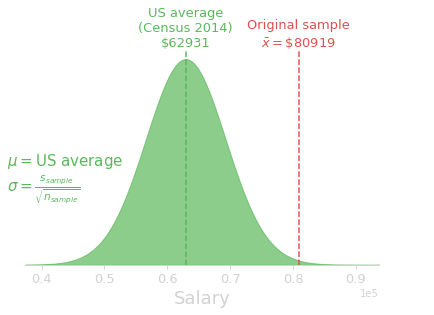

In [173]:
#t distribution
se_sample = (ucla_sample.GROSS.std())/np.sqrt(len(ucla_sample))
tdist_census = stats.t(df=len(ucla_sample)-1, loc=census2014["mean"], scale=se_sample)
xt_census = np.linspace(census2014["mean"]-4*se_sample, ucla_sample.GROSS.mean()+2*se_sample, 100000)
yt_census = tdist_census.pdf(xt_census)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes([0.1, 0.15, 0.82, 0.75])
ax2 = ax1.twinx()

    
for ax in [ax1]:
    ax.fill_between(xt_census, yt_census, color=colors["green"], alpha=0.7)
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.set_xlabel('Salary', size=18, color=colors["lightgray"])
    ax.set_xlim(xt_census.min(), xt_census.max())
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,5))
    ax.set_ylim(0)
    ax.axvline(census2014["mean"], color=colors["green"], ls="--")
    ax.text(census2014["mean"], ax.get_ylim()[1]*1.01, "US average\n(Census 2014)\n${:.0f}".format(census2014["mean"]), color=colors["green"], size=13, ha="center")
    ax.text(ax.get_xlim()[0]+(ax.get_xlim()[1]-ax.get_xlim()[0])*-0.05, ax.get_ylim()[1]*0.3, "$\mu=$US average\n" r"$\sigma=\frac{s_{sample}}{\sqrt{n_{sample}}}$", size=15, color=colors["green"], ha="left")
    
for ax in [ax2]:
    ax.set_ylim(ax1.get_ylim())
    ax.axvline(ucla_sample.GROSS.mean(), color=colors["red"], ls="--")
    ax.text(ucla_sample.GROSS.mean(), ax.get_ylim()[1]*1.01, "Original sample\n" r"$\bar{{x}}=$" "\${:.0f}".format(ucla_sample.GROSS.mean()), color=colors["red"], size=13, ha="center")
    ax.axis("off")

plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/salaries-ucla2014-ttest-hypothesized-dist.svg", transparent=True)

### bootstrap steps

In [73]:
n_simul = 10000
res_ucla_mean = np.zeros(n_simul)
res_ucla_median = np.zeros(n_simul)

for i in range(n_simul):
    res_ucla_mean[i]=np.random.choice(ucla_sample.GROSS.values, size=len(ucla_sample)).mean()
    res_ucla_median[i]=np.median(np.random.choice(ucla_sample.GROSS.values, size=len(ucla_sample)))

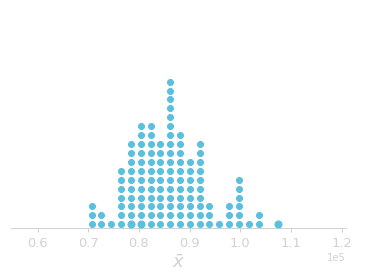

In [74]:
x1, y1 = st.to_dotplot(res_ucla_mean[:120], kind="bins", scale=0.05, nbins=20)

#randomize order of each rows of data points
rows_yval = np.unique(y1)
idx_by_rows = [list(np.where(y1 == val)[0]) for val in rows_yval]
for i in range(len(idx_by_rows)):
    np.random.shuffle(idx_by_rows[i])
shuffled_idx = np.concatenate(idx_by_rows)

x1 = x1[shuffled_idx]
y1 = y1[shuffled_idx]

fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()
ax5 = ax1.twinx()
ax6 = ax1.twinx()
ax7 = ax1.twinx()
ax8 = ax1.twinx()

for ax in [ax1]:
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.set_xlabel(r'$\bar{x}$', size=18, color=colors["lightgray"])
    ax.set_ylim(-0.02, 1.2)
    ax.set_xlim(xt_ucla.min(), xt_ucla.max())
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,5))

for ax in [ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    ax.set_ylim(ax1.get_ylim())
    ax.axis("off")
    
for ax in [ax2]:
    ax.scatter(x1[0], y1[0], s=50, color=colors["blue"])

for ax in [ax3]:
    ax.scatter(x1[1], y1[1], s=50, color=colors["blue"])

for ax in [ax4]:
    ax.scatter(x1[2], y1[2], s=50, color=colors["blue"])

for ax in [ax5]:
    ax.scatter(x1[3:25], y1[3:25], color=colors["blue"])

for ax in [ax6]:
    ax.scatter(x1[25:50], y1[25:50], color=colors["blue"])

for ax in [ax7]:
    ax.scatter(x1[50:80], y1[50:80], color=colors["blue"])

for ax in [ax8]:
    ax.scatter(x1[80:], y1[80:], color=colors["blue"])


plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/salaries-ucla2014-bootstrap-steps.svg", transparent=True)

## steps median

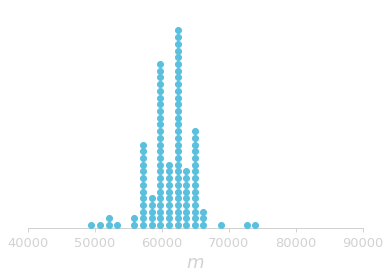

In [180]:
x1, y1 = st.to_dotplot(res_ucla_median[:120], kind="bins", scale=0.05, nbins=20)

#randomize order of each rows of data points
rows_yval = np.unique(y1)
idx_by_rows = [list(np.where(y1 == val)[0]) for val in rows_yval]
for i in range(len(idx_by_rows)):
    np.random.shuffle(idx_by_rows[i])
shuffled_idx = np.concatenate(idx_by_rows)

x1 = x1[shuffled_idx]
y1 = y1[shuffled_idx]

fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

for ax in [ax1]:
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.set_xlabel('$m$', size=18, color=colors["lightgray"])
    ax.set_ylim(-0.02, 1.6)
    ax.set_xlim(40000, 90000)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,5))

for ax in [ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    ax.set_ylim(ax1.get_ylim())
    ax.axis("off")
    

for ax in [ax2]:
    ax.scatter(x1[:50], y1[:50], color=colors["blue"])

for ax in [ax3]:
    ax.scatter(x1[50:], y1[50:], color=colors["blue"])


plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/salaries-ucla2014-bootstrap-steps-median.svg", transparent=True)

## Bootstrap median

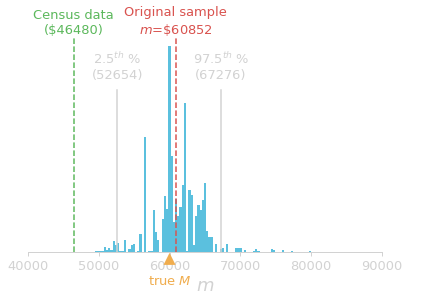

In [199]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes([0.1, 0.15, 0.82, 0.75])
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()
ax5 = ax1.twinx()

    
for ax in [ax1]:
    ax.hist(res_ucla_median, bins="auto", color=colors["blue"])
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.set_xlabel('$m$', size=18, color=colors["lightgray"])
    ax.set_xlim(40000, 90000)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,5))
    ax.set_ylim(0)
    
for ax in [ax2]:
    ax.set_ylim(ax1.get_ylim())
    ax.axvline(ucla_sample.GROSS.median(), color=colors["red"], ls="--")
    ax.text(ucla_sample.GROSS.median(), ax.get_ylim()[1]*1.01, "Original sample\n$m$=\${:.0f}".format(ucla_sample.GROSS.median()), color=colors["red"], size=13, ha="center")
 
for ax in [ax3]:
    ax.axvline(ucla_median_ci[0], ymax=0.75, color=colors["lightgray"], ls="-")
    ax.axvline(ucla_median_ci[1], ymax=0.75, color=colors["lightgray"], ls="-")
    ax.text(ucla_median_ci[0], ax.get_ylim()[1]*0.8, "2.5$^{{th}}$ %\n({:.0f})".format(ucla_median_ci[0]), color=colors["lightgray"], size=13, ha="center")
    ax.text(ucla_median_ci[1], ax.get_ylim()[1]*0.8, "97.5$^{{th}}$ %\n({:.0f})".format(ucla_median_ci[1]), color=colors["lightgray"], size=13, ha="center")

for ax in [ax4]:
    ax.axvline(census2014["median"], color=colors["green"], ls="--")
    ax.text(census2014["median"], ax.get_ylim()[1]*1.01, "Census data\n(\${:.0f})".format(census2014["median"]), color=colors["green"], size=13, ha="center")

for ax in [ax5]:
    ax.set_ylim(0, 1)
    ax.axis("off")
    #ax.axvline(data.GROSS.median(), ymax=0.92, color=colors["orange"], ls="--")
    ax.text(data.GROSS.median(), -0.15, "true $M$", color=colors["orange"], size=13, ha="center")
    ax.annotate('',
            xy=(data.GROSS.median(), 0), xycoords='data',
            xytext=(data.GROSS.median(), -0.01), textcoords='data',
            arrowprops=dict(facecolor=colors["orange"], ec="none", shrink=0.5),
            horizontalalignment='right', verticalalignment='top')

    
    
for ax in [ax2, ax3, ax4]:
    ax.set_ylim(0)
    ax.axis("off")

plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/salaries-ucla2014-resampling-median.svg", transparent=True)

## True sampling distribution

In [141]:
true_sampling = np.zeros(n_simul)
for i in range(n_simul):
    sample_idx = np.random.choice(data.index.values, replace=False, size=100)
    sample = data.ix[sample_idx]
    true_sampling[i]=sample.GROSS.mean()

In [142]:
#plt.hist(true_sampling, bins="auto");

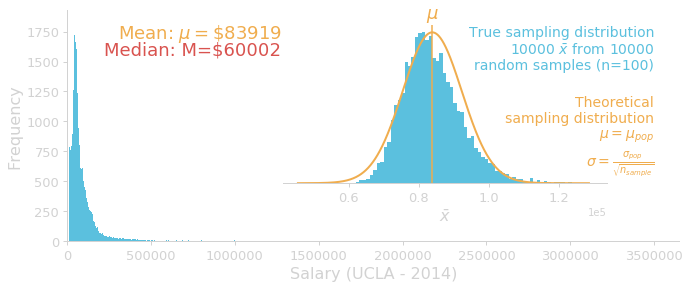

In [156]:
#t distribution
se_truesampling = (data.GROSS.std())/np.sqrt(len(ucla_sample))
tdist_truesampling = stats.t(df=len(ucla_sample)-1, loc=data.GROSS.mean(), scale=se_truesampling)
xt_truesampling = np.linspace(data.GROSS.mean()-6*se_sample, data.GROSS.mean()+7*se_sample, 10000)
yt_truesampling = tdist_truesampling.pdf(xt_truesampling)


fig = plt.figure(figsize=(10,4))
ax1 = fig.add_axes([0.1, 0.15, 0.85, 0.8])
ax2 = fig.add_axes([0.4, 0.35, 0.45, 0.55])
ax3 = ax2.twinx()


ax1.hist(data.GROSS, bins="auto", color=colors["blue"]);
ax2.hist(true_sampling, bins="auto", color=colors["blue"]);
ax3.plot(xt_truesampling, yt_truesampling, color=colors["orange"], lw=2);

for ax in [ax1]:
    for spine in ["bottom", "left"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_xlabel("Salary (UCLA - 2014)", size=16, color=colors["lightgray"])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.set_ylabel("Frequency", size=16, color=colors["lightgray"])
    ax.text(ax.get_xlim()[1]*0.35, ax.get_ylim()[1]*0.95, "Mean: $\mu=\$${:.0f}".format(data.GROSS.mean()), size=18, color=colors["orange"], ha="right", va="top")
    ax.text(ax.get_xlim()[1]*0.35, ax.get_ylim()[1]*0.87, "Median: M=${:.0f}".format(data.GROSS.median()), size=18, color=colors["red"], ha="right", va="top")
 
for ax in [ax2]:
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.text(ax.get_xlim()[1]*1.1, ax.get_ylim()[1]*1, "True sampling distribution\n10000 " r"$\bar{x}$" " from 10000\nrandom samples (n=100)", size=14, color=colors["blue"], ha="right", va="top")
    ax.set_yticks([])
    ax.set_xlabel(r"$\bar{x}$", size=16, color=colors["lightgray"])
    ax.tick_params(axis="x", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,5))
    ax.axvline(data.GROSS.mean(), color=colors["orange"])
    ax.text(data.GROSS.mean(), ax.get_ylim()[1]*1.04, "$\mu$", size=18, ha="center", color=colors["orange"])

for ax in [ax3]:
    ax.set_ylim(0)
    ax.text(ax.get_xlim()[1]*1.1, ax.get_ylim()[1]*0.5, "Theoretical\nsampling distribution\n$\mu=\mu_{pop}$\n" r"$\sigma=\frac{\sigma_{pop}}{\sqrt{n_{sample}}}$", size=14, color=colors["orange"], ha="right", va="top")
    ax.axis("off")
    
plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/salaries-ucla2014-true-sampling-distribution.svg", transparent=True)

## Central limit theorem for one sample mean

In [22]:
mu = 35
sigma = 5

#Population (gumbel left skewed)
gumbel_l = stats.gumbel_l(mu, sigma)

#Sample (normal)
n_sample = 40
ynorm = stats.norm(mu, sigma/np.sqrt(n_sample))#.rvs(n)



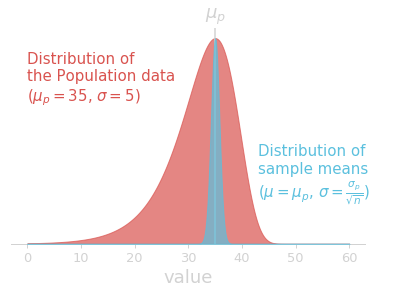

In [40]:
x = np.linspace(0, 60, 500)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes([0.1, 0.15, 0.82, 0.75])
ax2 = ax1.twinx()

for ax in [ax1]:
    ax.fill_between(x, gumbel_l.pdf(x), color=colors["red"], alpha=0.7)
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.set_xlabel('value', size=18, color=colors["lightgray"])
    ax.set_ylim(0)
    ax.text(0, 0.05, "Distribution of\nthe Population data\n($\mu_p=35$, $\sigma=5$)", size=15, color=colors["red"])
    ax.axvline(mu, color=colors["lightgray"])
    ax.text(mu, ax.get_ylim()[1]*1.04, "$\mu_p$", size=18, ha="center", color=colors["lightgray"])


for ax in [ax2]:
    ax.fill_between(x, ynorm.pdf(x), color=colors["blue"], alpha=0.7)
    ax.text(43, 0.1, "Distribution of\nsample means\n($\mu=\mu_p$, " r"$\sigma=\frac{\sigma_p}{\sqrt{n}}$)", size=15, color=colors["blue"])

    ax.set_ylim(0)


for ax in [ax2]:
    ax.axis("off")

plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/central-limit-theorem-one-mean.svg", transparent=True)

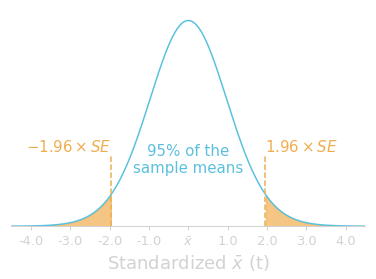

In [121]:
#t distribution
x = np.linspace(-4.5, 4.5, 1000)
y = stats.t(df=30, loc=0, scale=1).pdf(x)


fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes([0.1, 0.15, 0.82, 0.75])
   
for ax in [ax1]:
    ax.plot(x, y, color=colors["blue"], lw=1.5)
    ax.fill_between(x[x<-1.96], y[x<-1.96],
                       color=colors["orange"], alpha=0.7)
    ax.fill_between(x[x>1.96], y[x>1.96],
                        color=colors["orange"], alpha=0.7) 
    ax.axvline(1.96, ymax=0.33, color=colors["orange"], ls="--")
    ax.axvline(-1.96, ymax=0.33, color=colors["orange"], ls="--")
    ax.text(1.96, ax.get_ylim()[1]*0.35, r"$1.96\times SE$", color=colors["orange"], size=15, ha="left")
    ax.text(-1.96, ax.get_ylim()[1]*0.35, r"$-1.96\times SE$", color=colors["orange"], size=15, ha="right")
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.set_xlabel(r'Standardized $\bar{x}$ (t)', size=18, color=colors["lightgray"])
    ax.set_xlim(xt0_ucla.min(), xt0_ucla.max())
    ax.set_ylim(0)
    ax.text(0, ax.get_ylim()[1]*0.25, "95% of the\nsample means",
           ha="center", color=colors["blue"], size=15)
    xticklabels = [label.get_text() for label in ax.get_xticklabels()]
    middlelabelposition = int(len(xticklabels)/2)
    newlabels = np.concatenate([-1*np.arange(len(xticklabels)/2)[::-1][:-1],
                [r"$\bar{x}$"],
                np.arange(len(xticklabels)/2)[1:]])
    ax.set_xticklabels(newlabels)    

plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/central-limit-theorem-one-mean-ci95.svg", transparent=True)

In [113]:
np.concatenate([-1*np.arange(len(xticklabels)/2-1)[::-1][:-1],
                [r"$\bar{x}$"],
                np.arange(len(xticklabels)/2-1)[1:]])

array(['-4.0', '-3.0', '-2.0', '-1.0', '$\\bar{x}$', '1.0', '2.0', '3.0',
       '4.0'], 
      dtype='<U32')

In [111]:
-1*np.arange(len(xticklabels)/2-1)[::-1][:-1]

array([-4., -3., -2., -1.])

In [112]:
np.arange(len(xticklabels)/2-1)[1:]

array([ 1.,  2.,  3.,  4.])